## 1. Setup and Install Dependencies


In [3]:
# Install dependencies
!pip install -q SimpleITK
!git clone https://github.com/cwmok/LapIRN.git
!pip install torch==1.7.0 torchvision==0.8.1
!pip install numpy nibabel


fatal: destination path 'LapIRN' already exists and is not an empty directory.
ERROR: Could not find a version that satisfies the requirement torch==1.7.0 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0)
ERROR: No matching distribution found for torch==1.7.0


## 2. Import Libraries

In [4]:
import os
import numpy as np
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import pandas as pd


## 3. Preprocessing Utilities


In [5]:
# Normalize volume
def normalize(volume):
    v_min, v_max = np.min(volume), np.max(volume)
    return (volume - v_min) / (v_max - v_min + 1e-8)

# Convert and resize MHD to NIfTI
def mhd_to_nii(input_path, output_path, target_shape=(160, 192, 144)):
    img = sitk.ReadImage(input_path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    arr = normalize(arr)
    arr = resize(arr, target_shape, preserve_range=True, mode='reflect')
    nib.save(nib.Nifti1Image(arr, affine=np.eye(4)), output_path)
    print(f"Saved: {output_path}")


## 4. Single Patient Registration

In [8]:
# Paths (change from drive to dataset)

ct_path = "/content/drive/MyDrive/Data/rire/109/ct/patient_109_ct.mhd"
mri_path = "/content/drive/MyDrive/Data/rire/109/mr_T1/patient_109_mr_T1.mhd"

# replace with
#ct_path = "dataset/rire/ct/patient_109_ct.mhd"
#mri_path = "dataset/rire/mr_T1/patient_109_mr_T1.mhd"

# Output folders
lapirn_data_dir = "/content/LapIRN/Data"
lapirn_test_dir = "/content/LapIRN/Test"
os.makedirs(lapirn_data_dir, exist_ok=True)
os.makedirs(lapirn_test_dir, exist_ok=True)

# Preprocessing: Save NIfTI files
mhd_to_nii(ct_path, os.path.join(lapirn_data_dir, "image_A.nii"))
mhd_to_nii(mri_path, os.path.join(lapirn_data_dir, "image_B.nii"))

# Also save .npy versions (optional)
ct_array = sitk.GetArrayFromImage(sitk.ReadImage(ct_path))
mri_array = sitk.GetArrayFromImage(sitk.ReadImage(mri_path))

np.save(os.path.join(lapirn_test_dir, "rire_ct.npy"), resize(normalize(ct_array), (160, 192, 160)))
np.save(os.path.join(lapirn_test_dir, "rire_mri.npy"), resize(normalize(mri_array), (160, 192, 160)))

# Run LapIRN
!python /content/LapIRN/Code/Test_LapIRN_diff.py \
  --modelpath /content/LapIRN/Model/LapIRN_diff_fea7.pth \
  --fixed /content/LapIRN/Data/image_A.nii \
  --moving /content/LapIRN/Data/image_B.nii \
  --savepath /content/LapIRN/Result

Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


## 5. Visualization of Single Patient Results


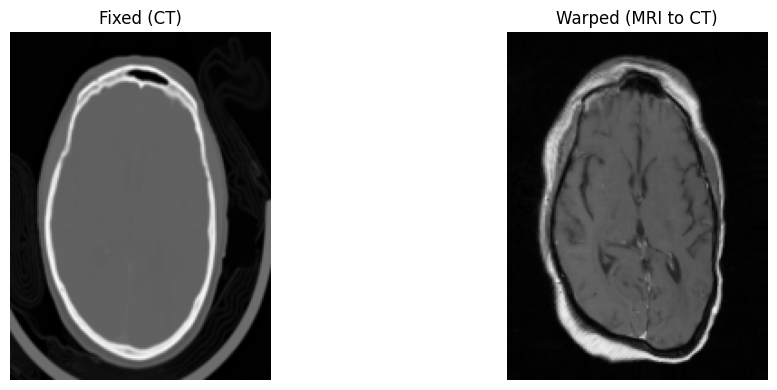

In [9]:
# Load images
fixed_img = nib.load("/content/LapIRN/Data/image_A.nii").get_fdata()
warped_img = nib.load("/content/LapIRN/Result/warpped_moving.nii.gz").get_fdata()

# Choose slice
z = fixed_img.shape[0] // 2

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(fixed_img[z], cmap="gray")
plt.title("Fixed (CT)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(warped_img[z], cmap="gray")
plt.title("Warped (MRI to CT)")
plt.axis("off")

plt.tight_layout()
plt.show()


## 6. Metric Computation for Single Patient

In [10]:
# Evaluate SSIM and MSE
fixed_slice = fixed_img[z]
warped_slice = warped_img[z]

fixed_norm = normalize(fixed_slice)
warped_norm = normalize(warped_slice)

ssim_val = ssim(fixed_norm, warped_norm, data_range=1.0)
mse_val = mean_squared_error(fixed_norm.flatten(), warped_norm.flatten())

print(f"SSIM: {ssim_val:.4f}")
print(f"MSE : {mse_val:.6f}")


SSIM: 0.4841
MSE : 0.026857


## 7. Full Dataset Batch Registration

In [12]:
# Configs
base_dir = "/content/drive/MyDrive/Data/rire"
# replace with
# base_dir = "dataset/rire"
lapirn_data_dir = "/content/LapIRN/Data"
model_path = "/content/LapIRN/Model/LapIRN_diff_fea7.pth"
results_dir = "/content/LapIRN_Batch_Results"
vis_dir = os.path.join(results_dir, "visuals")
csv_path = os.path.join(results_dir, "lapirn_results.csv")
target_shape = (160, 192, 144)

# Setup
os.makedirs(vis_dir, exist_ok=True)
batch_results = []

# Helper
def evaluate_slices(fixed, moving, axis=0):
    idx = fixed.shape[axis] // 2
    fixed_slice = np.take(fixed, idx, axis=axis)
    moving_slice = np.take(moving, idx, axis=axis)
    ssim_score = ssim(fixed_slice, moving_slice, data_range=1.0)
    mse_score = mean_squared_error(fixed_slice, moving_slice)
    return ssim_score, mse_score, fixed_slice, moving_slice

# Batch loop
for folder in tqdm(sorted(os.listdir(base_dir))):
    if not folder.isdigit():
        continue

    pid = folder
    ct_path = os.path.join(base_dir, pid, "ct", f"patient_{pid}_ct.mhd")
    mri_path = os.path.join(base_dir, pid, "mr_T1", f"patient_{pid}_mr_T1.mhd")

    if not os.path.exists(ct_path) or not os.path.exists(mri_path):
        print(f"Missing data for patient {pid}")
        continue

    print(f"Running LapIRN for patient {pid}")

    # Step 1: Convert and Save
    fixed_nii_path = os.path.join(lapirn_data_dir, "image_A.nii")
    moving_nii_path = os.path.join(lapirn_data_dir, "image_B.nii")
    mhd_to_nii(ct_path, fixed_nii_path)
    mhd_to_nii(mri_path, moving_nii_path)

    # Step 2: Run LapIRN
    output_dir = os.path.join(results_dir, pid)
    os.makedirs(output_dir, exist_ok=True)

    !python /content/LapIRN/Code/Test_LapIRN_diff.py \
      --modelpath {model_path} \
      --fixed {fixed_nii_path} \
      --moving {moving_nii_path} \
      --savepath {output_dir}

    # Step 3: Load and Evaluate
    try:
        fixed_nii = nib.load(fixed_nii_path).get_fdata()
        warped_path = os.path.join(output_dir, "warpped_moving.nii.gz")
        warped_nii = nib.load(warped_path).get_fdata()
    except Exception as e:
        print(f"Error loading images for patient {pid}: {e}")
        continue

    ssim_val, mse_val, fixed_slice, warped_slice = evaluate_slices(fixed_nii, warped_nii)

    # Step 4: Visualization
    vis_path = os.path.join(vis_dir, f"patient_{pid}.png")
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_slice, cmap='gray')
    plt.title("Fixed (CT)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(warped_slice, cmap='gray')
    plt.title("Warped (MRI to CT)")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(vis_path)
    plt.close()

    # Log results
    batch_results.append({
        "patient": pid,
        "ssim": ssim_val,
        "mse": mse_val
    })

# Save CSV
df = pd.DataFrame(batch_results)
df.to_csv(csv_path, index=False)
print(f"Saved batch metrics to {csv_path}")


  0%|          | 0/14 [00:00<?, ?it/s]

Running LapIRN for patient 02
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


  7%|▋         | 1/14 [00:08<01:44,  8.02s/it]

Running LapIRN for patient 03
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 14%|█▍        | 2/14 [00:15<01:35,  7.99s/it]

Running LapIRN for patient 04
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 21%|██▏       | 3/14 [00:23<01:27,  7.97s/it]

Running LapIRN for patient 05
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 29%|██▊       | 4/14 [00:31<01:19,  7.93s/it]

Running LapIRN for patient 06
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 36%|███▌      | 5/14 [00:39<01:11,  7.95s/it]

Running LapIRN for patient 07
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 43%|████▎     | 6/14 [00:47<01:03,  7.98s/it]

Running LapIRN for patient 101
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 50%|█████     | 7/14 [00:55<00:56,  8.02s/it]

Running LapIRN for patient 102
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 57%|█████▋    | 8/14 [01:06<00:53,  8.95s/it]

Running LapIRN for patient 103
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 64%|██████▍   | 9/14 [01:17<00:47,  9.50s/it]

Running LapIRN for patient 104
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 71%|███████▏  | 10/14 [01:28<00:39,  9.86s/it]

Running LapIRN for patient 105
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 79%|███████▊  | 11/14 [01:39<00:30, 10.14s/it]

Running LapIRN for patient 107
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 86%|████████▌ | 12/14 [01:49<00:20, 10.15s/it]

Running LapIRN for patient 108
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


 93%|█████████▎| 13/14 [01:59<00:10, 10.18s/it]

Running LapIRN for patient 109
Saved: /content/LapIRN/Data/image_A.nii
Saved: /content/LapIRN/Data/image_B.nii
Finished


100%|██████████| 14/14 [02:07<00:00,  9.12s/it]

Saved batch metrics to /content/LapIRN_Batch_Results/lapirn_results.csv
